Installing river library


In [1]:
!pip install river

Importing required libraries and dependencies


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.preprocessing import LabelEncoder
from river import forest, drift, metrics
import math
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    accuracy_score, confusion_matrix, classification_report
)
from river import forest, metrics, drift, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

Loading and inspecting the fraud dataset


In [3]:
df = pd.read_csv('/content/fraudTrain.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
display(df.head())
print("\nDataset info:")
print(df.info())

Dataset shape: (1048575, 25)

First few rows:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,Unnamed: 23,6006
0,0,1/1/19 0:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",3/9/88,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,NaN,NaN
1,1,1/1/19 0:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,6/21/78,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN,NaN
2,2,1/1/19 0:00,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1/19/62,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,NaN,NaN
3,3,1/1/19 0:01,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1/12/67,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN,NaN
4,4,1/1/19 0:03,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,3/28/86,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,NaN,NaN



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 25 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1048575 non-null  int64  
 1   trans_date_trans_time  1048575 non-null  object 
 2   cc_num                 1048575 non-null  float64
 3   merchant               1048575 non-null  object 
 4   category               1048575 non-null  object 
 5   amt                    1048575 non-null  float64
 6   first                  1048575 non-null  object 
 7   last                   1048575 non-null  object 
 8   gender                 1048575 non-null  object 
 9   street                 1048575 non-null  object 
 10  city                   1048575 non-null  object 
 11  state                  1048575 non-null  object 
 12  zip                    1048575 non-null  int64  
 13  lat                    1048575 non-null  float64
 14  lon

Analyzing dataset structure and class distribution


In [4]:
print(f" Dataset Shape: {df.shape}")
print(" Column Overview:")
print(df.dtypes.value_counts())
print("\n" + "="*60)
print(" Class Distribution:")
print(df['is_fraud'].value_counts().sort_index())
print("\n" + "="*60)
print(" Missing Values (Top 5):")
print(df.isnull().sum().sort_values(ascending=False).head())

 Dataset Shape: (1048575, 25)
 Column Overview:
object     12
float64     8
int64       5
Name: count, dtype: int64

 Class Distribution:
is_fraud
0    1042569
1       6006
Name: count, dtype: int64

 Missing Values (Top 5):
6006                     1048575
Unnamed: 23              1048575
cc_num                         0
trans_date_trans_time          0
category                       0
dtype: int64


Checking for duplicate records in the dataset


In [5]:
duplicates = df.duplicated().sum()
print(f" Duplicates: {duplicates} ({duplicates/len(df)*100:.4f}%)")

 Duplicates: 0 (0.0000%)


Analyzing summary statistics of numerical columns


In [6]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,Unnamed: 23,6006
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,0.0,0.0
mean,5.242870e+05,4.171565e+17,7.027910e+01,4.880159e+04,3.853336e+01,-9.022626e+01,8.905776e+04,1.344906e+09,3.853346e+01,-9.022648e+01,5.727773e-03,NaN,NaN
std,3.026977e+05,1.308811e+18,1.599518e+02,2.689804e+04,5.076852e+00,1.375858e+01,3.024351e+05,1.019700e+07,5.111233e+00,1.377093e+01,7.546503e-02,NaN,NaN
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,NaN,NaN
25%,2.621435e+05,1.800400e+14,9.640000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.336682e+09,3.472954e+01,-9.689864e+01,0.000000e+00,NaN,NaN
50%,5.242870e+05,3.520550e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.344902e+09,3.936295e+01,-8.743923e+01,0.000000e+00,NaN,NaN
75%,7.864305e+05,4.642260e+15,8.305000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.354366e+09,4.195602e+01,-8.023228e+01,0.000000e+00,NaN,NaN
max,1.048574e+06,4.992350e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.362932e+09,6.751027e+01,-6.695090e+01,1.000000e+00,NaN,NaN


Dropping irrelevant and redundant columns from the dataset


In [7]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 23', '6006', 'trans_num', 'cc_num'])
print("Shape after dropping irrelevant columns:", df.shape)

Shape after dropping irrelevant columns: (1048575, 20)


Extracting temporal features from transaction timestamp


In [8]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.dayofweek
df['month'] = df['trans_date_trans_time'].dt.month

df = df.drop(columns=['trans_date_trans_time'])

Calculating customer age from date of birth


In [9]:
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (pd.Timestamp.now() - df['dob']).dt.days // 365.25
df = df.drop(columns=['dob'])

Displaying dataset information after feature engineering


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1048575 non-null  object 
 1   category    1048575 non-null  object 
 2   amt         1048575 non-null  float64
 3   first       1048575 non-null  object 
 4   last        1048575 non-null  object 
 5   gender      1048575 non-null  object 
 6   street      1048575 non-null  object 
 7   city        1048575 non-null  object 
 8   state       1048575 non-null  object 
 9   zip         1048575 non-null  int64  
 10  lat         1048575 non-null  float64
 11  long        1048575 non-null  float64
 12  city_pop    1048575 non-null  int64  
 13  job         1048575 non-null  object 
 14  unix_time   1048575 non-null  int64  
 15  merch_lat   1048575 non-null  float64
 16  merch_long  1048575 non-null  float64
 17  is_fraud    1048575 non-null  int64  
 18  hour        1048575 no

Checking for duplicate rows in the dataset


In [11]:
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("\nDuplicate rows preview:")
    display(df[df.duplicated()].head())
else:
    print("\nNo duplicate rows found.")

Total duplicate rows: 0

No duplicate rows found.


Analyzing unique values and distributions for all dataset columns


 Column: merchant
   Unique values: 693
merchant
fraud_Kilback LLC                   3521
fraud_Cormier LLC                   2986
fraud_Schumm PLC                    2921
fraud_Boyer PLC                     2833
fraud_Kuhn LLC                      2827
fraud_Dickinson Ltd                 2775
fraud_Olson, Becker and Koch        2233
fraud_Stroman, Hudson and Erdman    2232
fraud_Rodriguez Group               2208
fraud_Bartoletti-Wunsch             2205
Name: count, dtype: int64


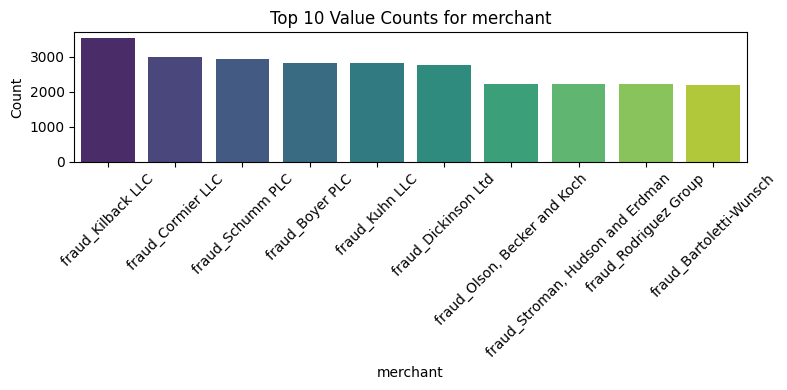

 Column: category
   Unique values: 14
category
gas_transport     106430
grocery_pos        99906
home               99578
shopping_pos       94353
kids_pets          91404
shopping_net       78899
entertainment      75981
food_dining        74041
personal_care      73498
health_fitness     69362
Name: count, dtype: int64


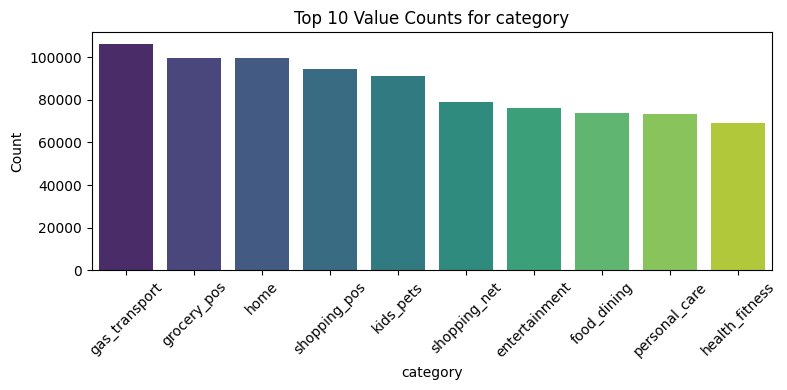

 Column: amt
   Unique values: 48602


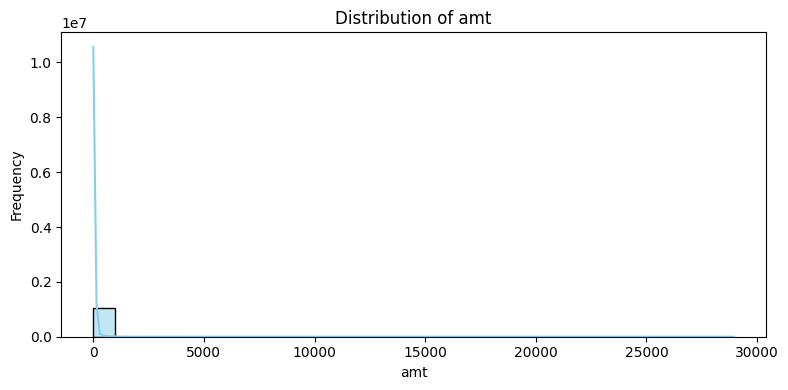

 Column: first
   Unique values: 348
first
Christopher    21518
Robert         17474
Jessica        16654
Michael        16142
David          16079
James          16074
Jennifer       13765
John           13283
Mary           13234
William        13162
Name: count, dtype: int64


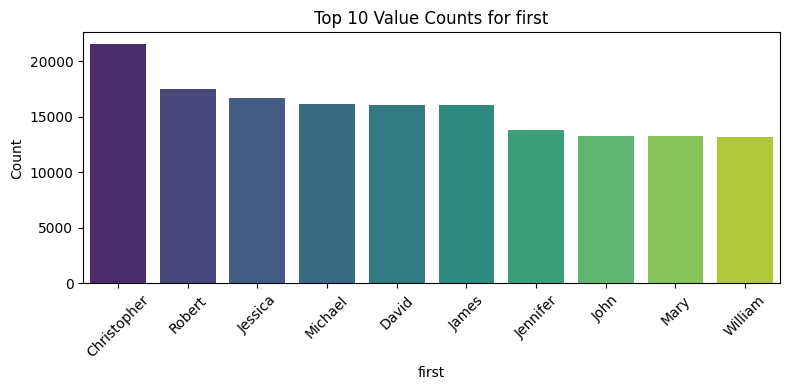

 Column: last
   Unique values: 479
last
Smith        23394
Williams     19036
Davis        17674
Johnson      16292
Rodriguez    14065
Martinez     11950
Jones        11338
Lewis        10269
Gonzalez      9520
Miller        9464
Name: count, dtype: int64


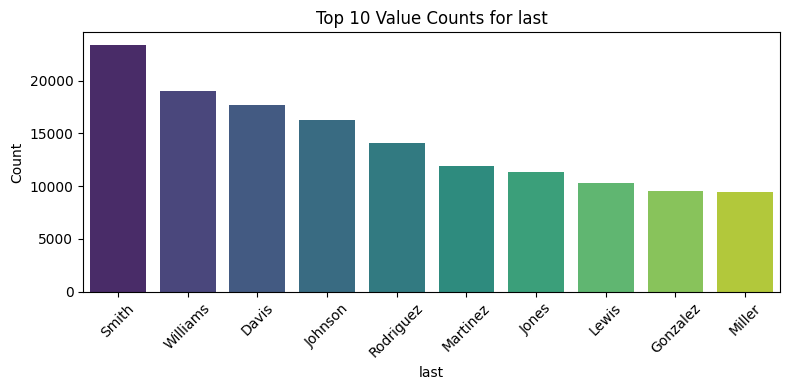

 Column: gender
   Unique values: 2
gender
F    573968
M    474607
Name: count, dtype: int64


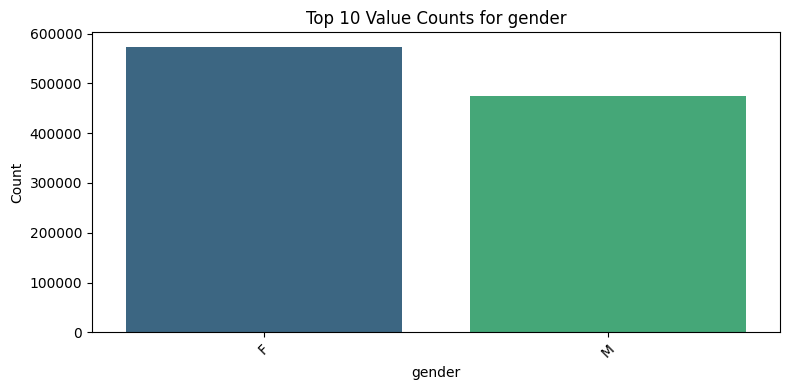

 Column: street
   Unique values: 965
street
4664 Sanchez Common Suite 930        2566
854 Walker Dale Suite 488            2559
29606 Martinez Views Suite 653       2542
2870 Bean Terrace Apt. 756           2532
8030 Beck Motorway                   2531
40624 Rebecca Spurs                  2529
594 Berry Lights Apt. 392            2525
8172 Robertson Parkways Suite 072    2522
0069 Robin Brooks Apt. 695           2521
574 David Locks Suite 207            2518
Name: count, dtype: int64


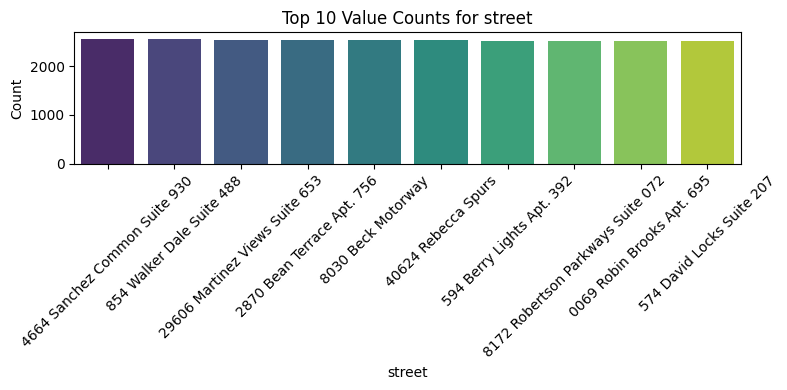

 Column: city
   Unique values: 879
city
Birmingham     4499
San Antonio    4152
Meridian       4149
Phoenix        4119
Utica          4115
Thomas         3773
Conway         3726
Cleveland      3717
Warren         3715
Houston        3389
Name: count, dtype: int64


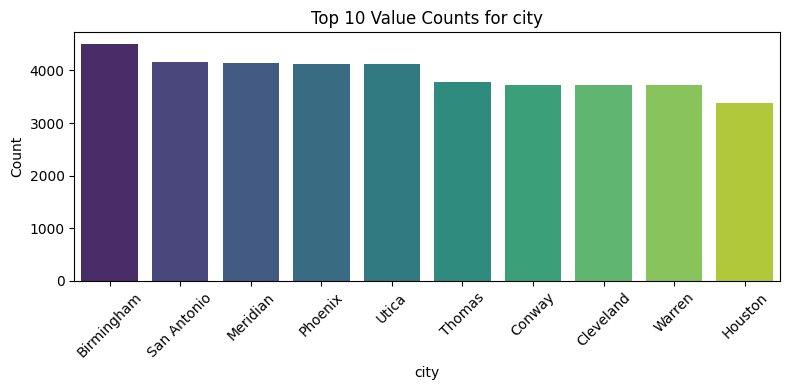

 Column: state
   Unique values: 51
state
TX    76731
NY    67366
PA    64475
CA    45711
OH    37422
MI    37219
IL    35066
FL    34695
AL    33226
MO    31055
Name: count, dtype: int64


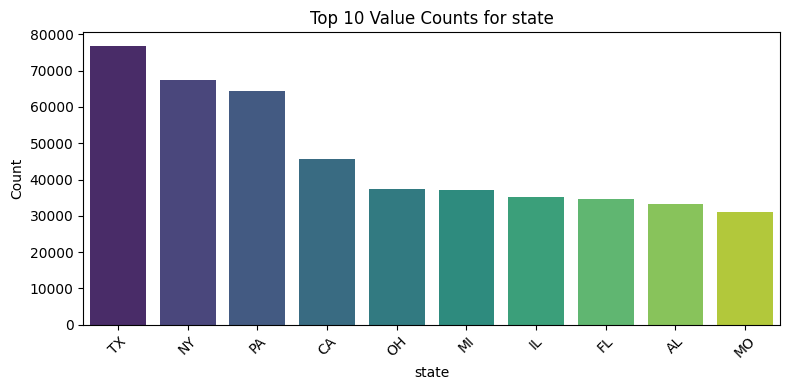

 Column: zip
   Unique values: 952


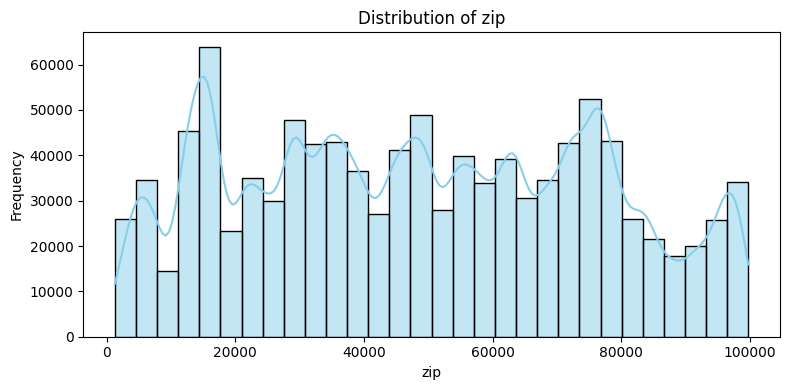

 Column: lat
   Unique values: 950


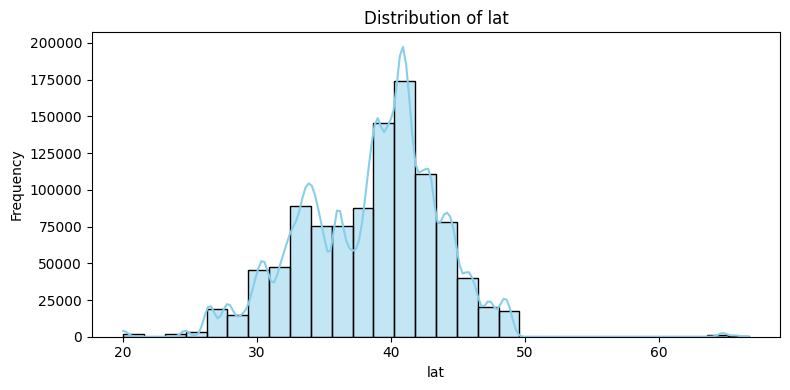

 Column: long
   Unique values: 951


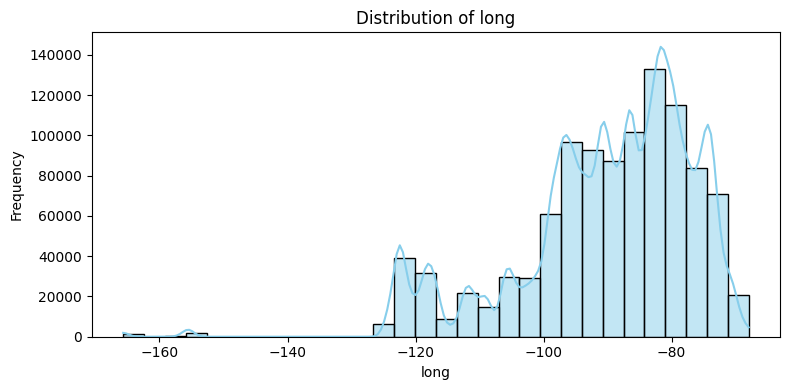

 Column: city_pop
   Unique values: 865


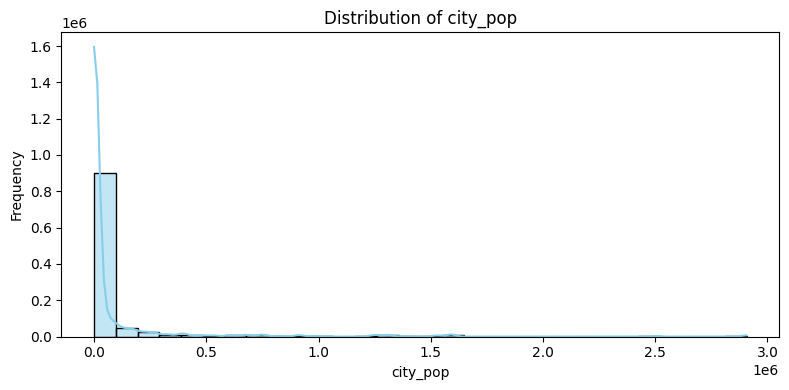

 Column: job
   Unique values: 493
job
Film/video editor             7940
Exhibition designer           7393
Surveyor, land/geomatics      7049
Naval architect               7000
Materials engineer            6695
Designer, ceramics/pottery    6662
Systems developer             6272
IT trainer                    6238
Financial adviser             6175
Environmental consultant      6142
Name: count, dtype: int64


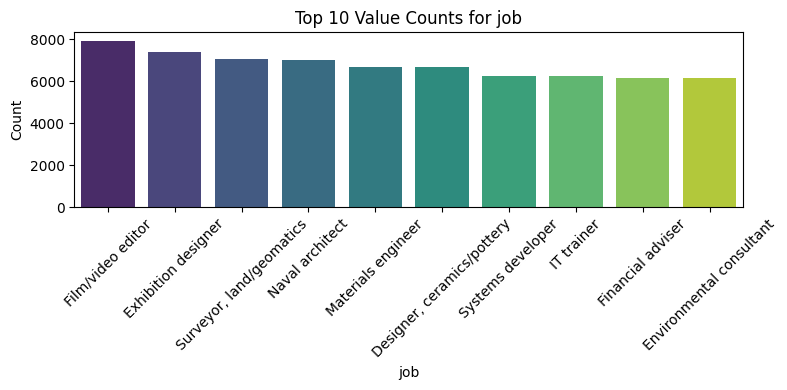

 Column: unix_time
   Unique values: 1030650


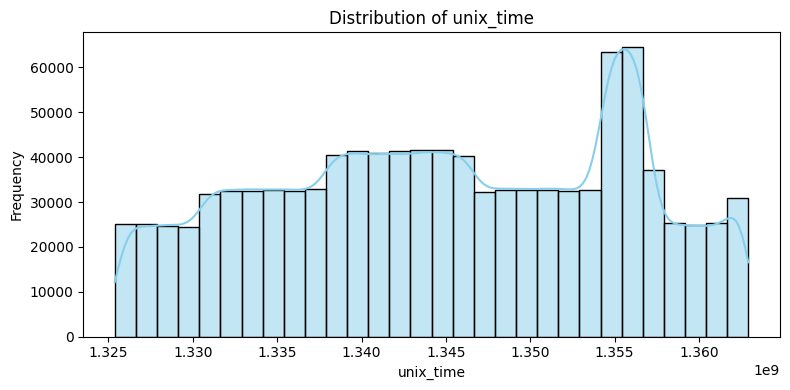

 Column: merch_lat
   Unique values: 1016437


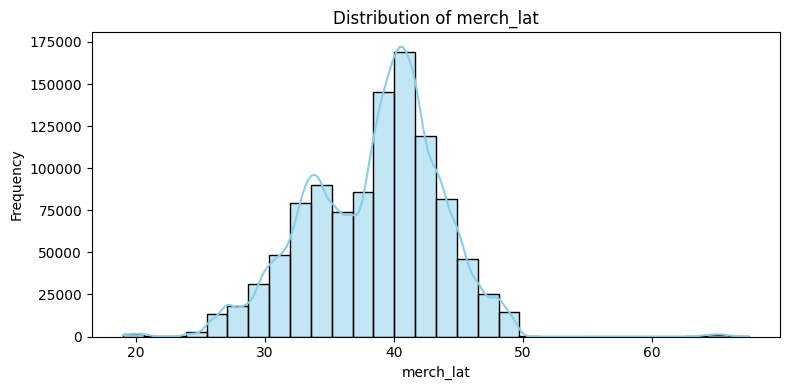

 Column: merch_long
   Unique values: 1034825


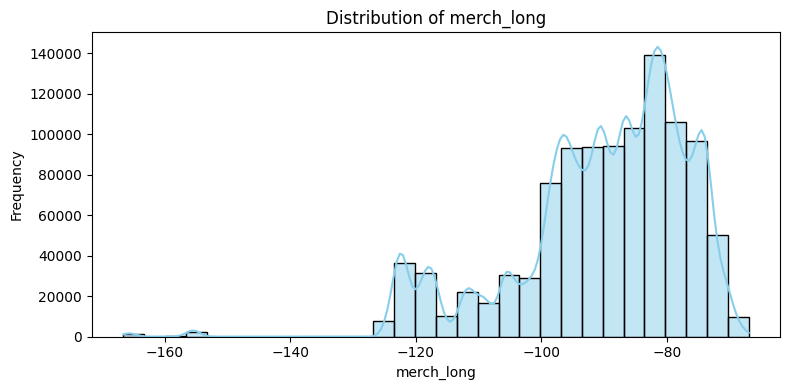

 Column: is_fraud
   Unique values: 2
is_fraud
0    1042569
1       6006
Name: count, dtype: int64


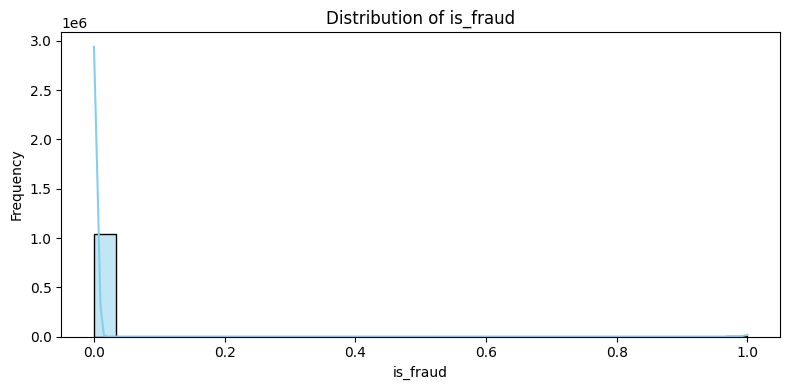

 Column: hour
   Unique values: 24


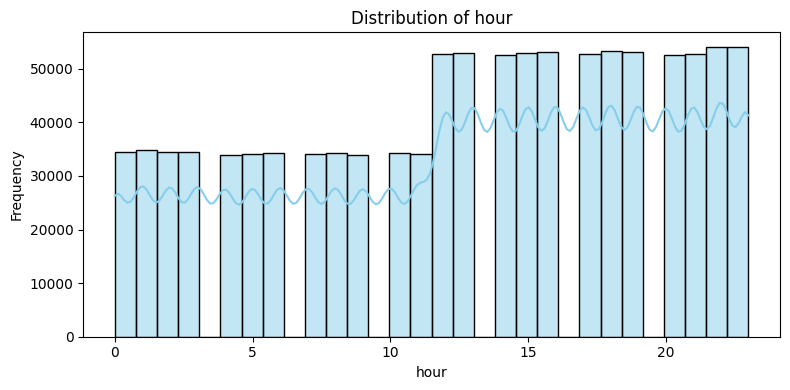

 Column: day
   Unique values: 7
day
6    208931
0    205696
5    171241
4    122436
3    120426
1    112597
2    107248
Name: count, dtype: int64


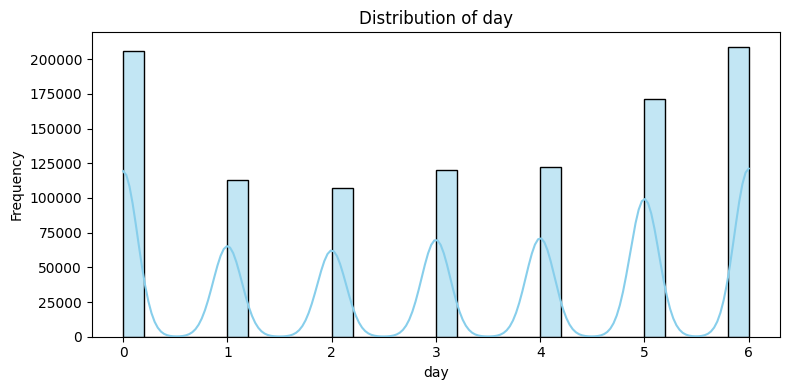

 Column: month
   Unique values: 12
month
12    141060
1     104727
2      97657
3      94671
8      87359
7      86596
6      86064
5      72532
9      70652
11     70421
Name: count, dtype: int64


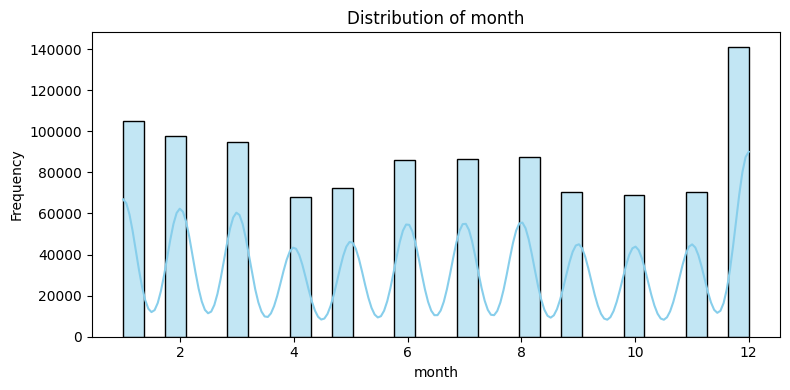

 Column: age
   Unique values: 83


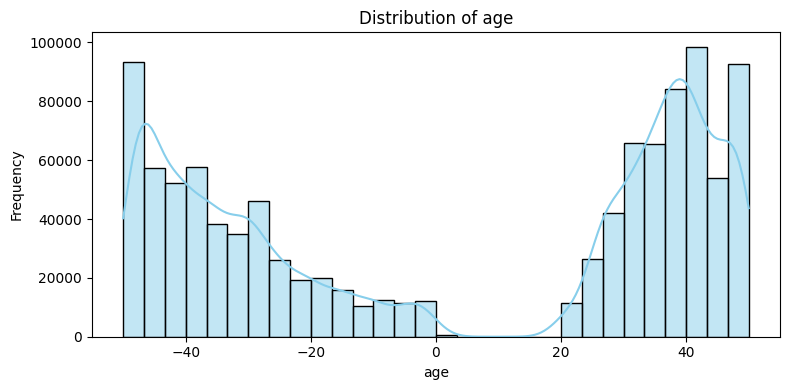

In [12]:
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f" Column: {col}")
    print(f"   Unique values: {unique_vals}")

    if df[col].dtype == 'object' or unique_vals < 20:
        print(df[col].value_counts().head(10))
    plt.figure(figsize=(8, 4))

    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(df[col], bins=30, kde=True, color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    else:
        top_vals = df[col].value_counts().head(10)
        sns.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")
        plt.title(f"Top 10 Value Counts for {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Checking and visualizing missing values across all dataset columns


In [13]:
missing_summary = (
    df.isnull().sum()
    .reset_index()
    .rename(columns={'index': 'Column', 0: 'Missing_Count'})
)
missing_summary['Missing_Percentage'] = (missing_summary['Missing_Count'] / len(df)) * 100
missing_summary = missing_summary.sort_values(by='Missing_Percentage', ascending=False)
print(" Missing Value Summary (Top 10):")
display(missing_summary.head(10))

if missing_summary['Missing_Count'].sum() > 0:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=missing_summary.head(20), x='Missing_Percentage', y='Column', palette='coolwarm')
    plt.title("Missing Values by Column (Top 20)")
    plt.xlabel("Percentage of Missing Values (%)")
    plt.ylabel("Columns")
    plt.tight_layout()
    plt.show()
else:
    print(" No missing values found in the dataset.")

 Missing Value Summary (Top 10):


,Column,Missing_Count,Missing_Percentage
0,merchant,0,0.0
1,category,0,0.0
2,amt,0,0.0
3,first,0,0.0
4,last,0,0.0
5,gender,0,0.0
6,street,0,0.0
7,city,0,0.0
8,state,0,0.0
9,zip,0,0.0


 No missing values found in the dataset.


Performing comprehensive data preprocessing and feature transformation


In [14]:
df = df.drop(columns=['first', 'last', 'street', 'city', 'zip'], errors='ignore')
def haversine_vectorized(df):
    lat1, lon1 = df['lat'].values, df['long'].values
    lat2, lon2 = df['merch_lat'].values, df['merch_long'].values
    R = 6371

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

df['distance_km'] = haversine_vectorized(df)
df = df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], errors='ignore')
df['log_amt'] = np.log1p(df['amt'])

cat_cols = ['merchant', 'category', 'gender', 'state', 'job']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

df = df.sort_values('unix_time').reset_index(drop=True)
print(f"Fraud ratio: {df['is_fraud'].mean():.4f}")
print("\nFinal columns:", df.columns.tolist())
print(f"\nShape: {df.shape}")

Fraud ratio: 0.0057

Final columns: ['merchant', 'category', 'amt', 'gender', 'state', 'city_pop', 'job', 'unix_time', 'is_fraud', 'hour', 'day', 'month', 'age', 'distance_km', 'log_amt']

Shape: (1048575, 15)


Validating temporal sorting and summarizing transaction distance and amount statistics


In [15]:
print("Fraud rate:", df['is_fraud'].mean())
assert df['unix_time'].is_monotonic_increasing, "Data not sorted by time!"

print("\nDistance stats (km):")
print(df['distance_km'].describe())
print("\nAmount stats:")
print(df['amt'].describe())

Fraud rate: 0.005727773406766326

Distance stats (km):
count    1.048575e+06
mean     7.610218e+01
std      2.911262e+01
min      2.225452e-02
25%      5.533249e+01
50%      7.821087e+01
75%      9.847991e+01
max      1.521172e+02
Name: distance_km, dtype: float64

Amount stats:
count    1.048575e+06
mean     7.027910e+01
std      1.599518e+02
min      1.000000e+00
25%      9.640000e+00
50%      4.745000e+01
75%      8.305000e+01
max      2.894890e+04
Name: amt, dtype: float64


Analyzing fraud rate trends over time and distance distribution


 Fraud Rate: 0.5728% (0.005728)
    Severe imbalance confirmed (typical in fraud datasets)


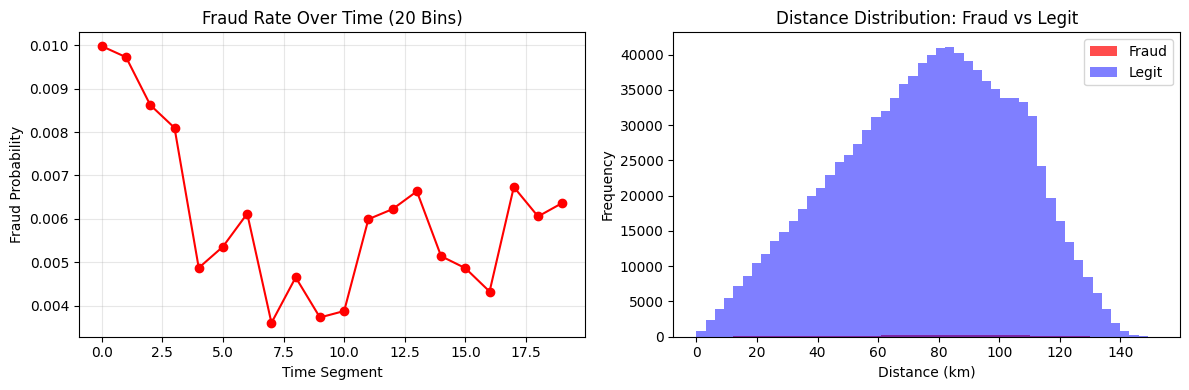

In [16]:
fraud_rate = df['is_fraud'].mean()
print(f" Fraud Rate: {fraud_rate:.4%} ({fraud_rate:.6f})")
print(f"    Severe imbalance confirmed (typical in fraud datasets)")
df['time_bin'] = pd.cut(df['unix_time'], bins=20, labels=False)
fraud_by_time = df.groupby('time_bin')['is_fraud'].agg(['mean', 'count'])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fraud_by_time.index, fraud_by_time['mean'], 'o-', color='red')
plt.title('Fraud Rate Over Time (20 Bins)')
plt.ylabel('Fraud Probability')
plt.xlabel('Time Segment')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df[df['is_fraud'] == 1]['distance_km'], bins=50, alpha=0.7, label='Fraud', color='red')
plt.hist(df[df['is_fraud'] == 0]['distance_km'], bins=50, alpha=0.5, label='Legit', color='blue')
plt.title('Distance Distribution: Fraud vs Legit')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

Comparing feature distributions between fraudulent and legitimate transactions


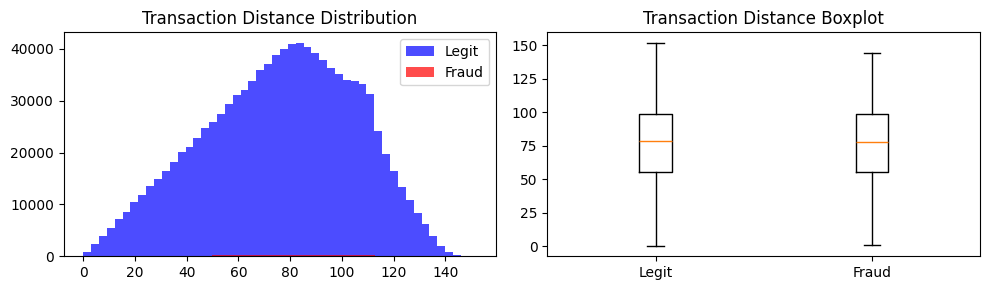

  Mann-Whitney U test for distance_km: p-value = 8.52e-01


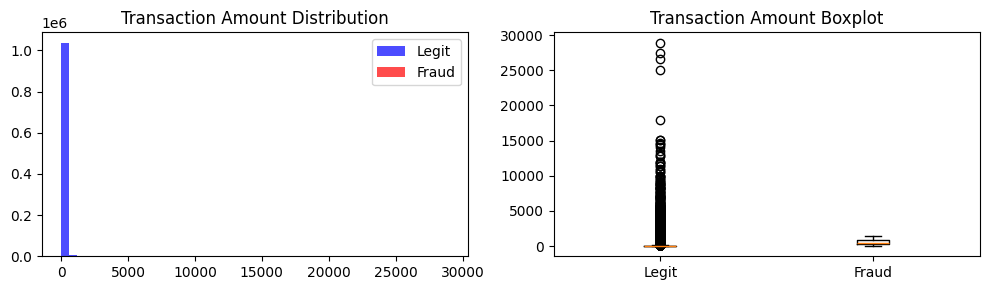

  Mann-Whitney U test for amt: p-value = 0.00e+00
  ==> Strong evidence distributions differ (p < 0.001)


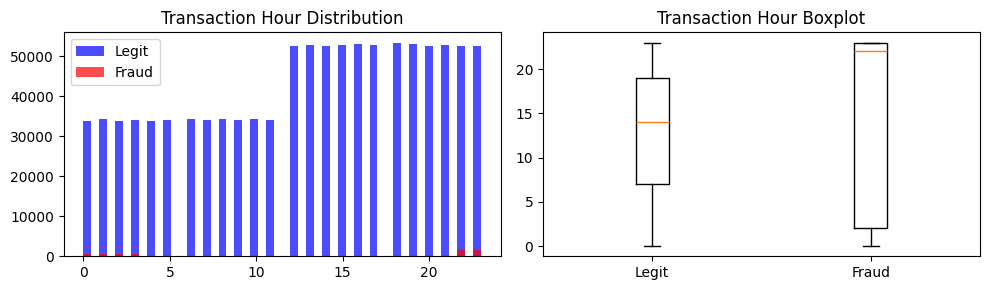

  Mann-Whitney U test for hour: p-value = 4.98e-102
  ==> Strong evidence distributions differ (p < 0.001)


In [17]:
def compare_distributions(feature, title=None):
    fraud_data = df[df['is_fraud'] == 1][feature]
    legit_data = df[df['is_fraud'] == 0][feature]

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(legit_data, bins=50, alpha=0.7, label='Legit', color='blue')
    plt.hist(fraud_data, bins=50, alpha=0.7, label='Fraud', color='red')
    plt.title(f'{title or feature} Distribution')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot([legit_data, fraud_data], labels=['Legit', 'Fraud'])
    plt.title(f'{title or feature} Boxplot')
    plt.tight_layout()
    plt.show()

    from scipy.stats import mannwhitneyu
    stat, p = mannwhitneyu(fraud_data, legit_data, alternative='two-sided')
    print(f"  Mann-Whitney U test for {feature}: p-value = {p:.2e}")
    if p < 0.001:
        print(f"  ==> Strong evidence distributions differ (p < 0.001)")

compare_distributions('distance_km', 'Transaction Distance')
compare_distributions('amt', 'Transaction Amount')
compare_distributions('hour', 'Transaction Hour')

Checking and ensuring chronological ordering of transaction timestamps


In [18]:
is_sorted = df['unix_time'].is_monotonic_increasing
is_strictly_sorted = is_sorted and df['unix_time'].is_unique

print(f" Temporal Order Check:")
print(f"   Monotonic increasing: {is_sorted}")
print(f"   Strictly increasing: {is_strictly_sorted}")

if not is_strictly_sorted:
    np.random.seed(42)
    jitter = np.random.uniform(0, 1e-3, size=len(df))
    df['unix_time'] = df['unix_time'] + jitter
    df = df.sort_values('unix_time').reset_index(drop=True)
    print("    Timestamps adjusted and re-sorted.")

 Temporal Order Check:
   Monotonic increasing: True
   Strictly increasing: False
    Timestamps adjusted and re-sorted.


Evaluating correlation between key features and fraud occurrence


In [19]:
print(" Feature-Target Association (Point-Biserial Correlation):")
features_for_corr = ['distance_km', 'log_amt', 'hour', 'day', 'city_pop', 'age']
for feat in features_for_corr:
    corr, pval = pointbiserialr(df['is_fraud'], df[feat])
    print(f"  {feat:12}: r = {corr:6.3f}, p = {pval:.2e}")

 Feature-Target Association (Point-Biserial Correlation):
  distance_km : r =  0.000, p = 7.18e-01
  log_amt     : r =  0.119, p = 0.00e+00
  hour        : r =  0.012, p = 4.91e-37
  day         : r =  0.001, p = 1.52e-01
  city_pop    : r =  0.002, p = 6.19e-02
  age         : r = -0.010, p = 3.70e-26


Identifying high-risk fraud indicators based on transaction patterns


In [20]:
print(" Top Fraud Indicators (Conditional Probability):")
high_risk = df[(df['distance_km'] > df['distance_km'].quantile(0.95)) &
               (df['amt'] > df['amt'].quantile(0.95))]
fraud_in_high_risk = high_risk['is_fraud'].mean()
print(f"  Fraud rate in top 5% distance+amount: {fraud_in_high_risk:.4%}")

night_mask = (df['hour'] >= 22) | (df['hour'] <= 5)
fraud_night = df[night_mask]['is_fraud'].mean()
fraud_day = df[~night_mask]['is_fraud'].mean()
print(f"  Fraud rate at night: {fraud_night:.4%} vs day: {fraud_day:.4%} (RR = {fraud_night/fraud_day:.2f}x)")

 Top Fraud Indicators (Conditional Probability):
  Fraud rate in top 5% distance+amount: 7.9313%
  Fraud rate at night: 1.6467% vs day: 0.1129% (RR = 14.58x)


Visualizing fraud versus legitimate transaction distribution


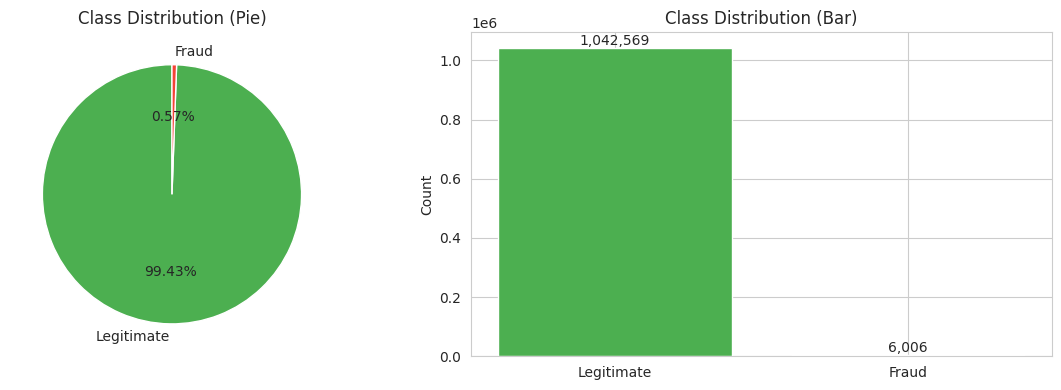

In [21]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
df['time_bin_cat'] = pd.Categorical(df['time_bin'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fraud_counts = df['is_fraud'].value_counts()
ax1.pie(fraud_counts, labels=['Legitimate', 'Fraud'], autopct='%1.2f%%',
        colors=['#4CAF50', '#F44336'], startangle=90)
ax1.set_title('Class Distribution (Pie)')

ax2.bar(['Legitimate', 'Fraud'], fraud_counts, color=['#4CAF50', '#F44336'])
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution (Bar)')
for i, v in enumerate(fraud_counts):
    ax2.text(i, v + 10000, f"{v:,}", ha='center')
plt.tight_layout()
plt.show()

Visualizing transaction amount distribution before and after log transformation


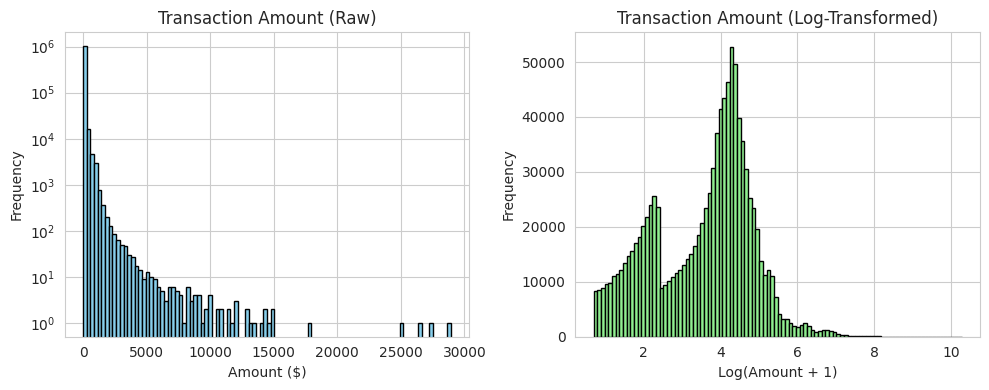

In [22]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['amt'], bins=100, color='skyblue', edgecolor='black')
plt.title('Transaction Amount (Raw)')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(df['log_amt'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Transaction Amount (Log-Transformed)')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Analyzing variation in fraud probability across different hours of the day


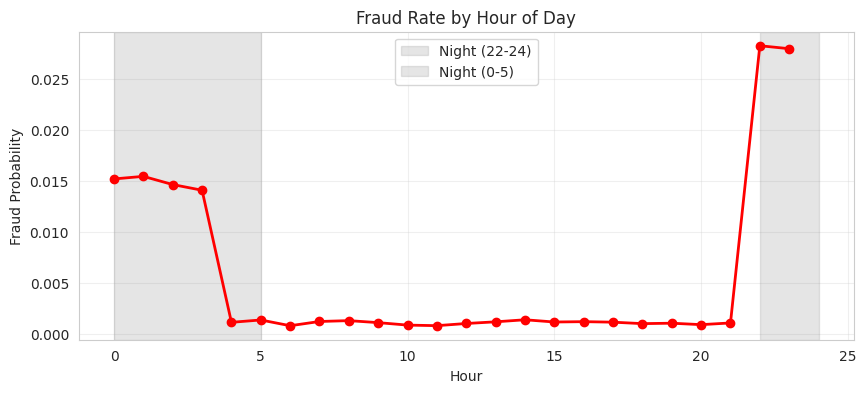

In [23]:
fraud_by_hour = df.groupby('hour')['is_fraud'].mean()
plt.figure(figsize=(10, 4))
plt.plot(fraud_by_hour.index, fraud_by_hour.values, 'o-', color='red', linewidth=2)
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Probability')
plt.grid(True, alpha=0.3)
plt.axvspan(22, 24, color='gray', alpha=0.2, label='Night (22-24)')
plt.axvspan(0, 5, color='gray', alpha=0.2, label='Night (0-5)')
plt.legend()
plt.show()

Comparing transaction distance between fraudulent and legitimate transactions


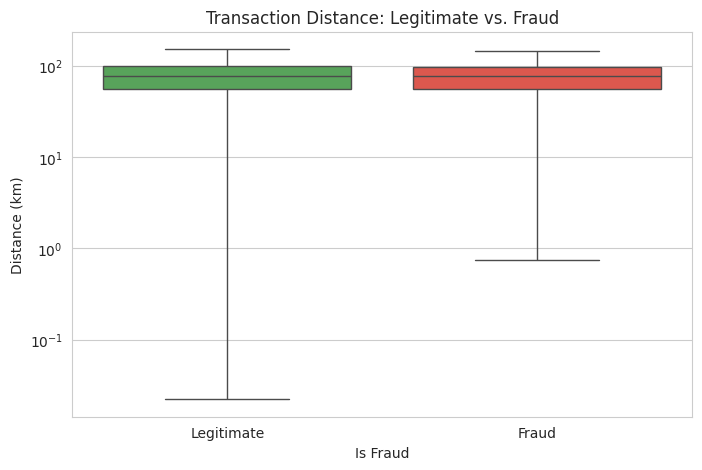

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='is_fraud', y='distance_km',
            palette=['#4CAF50', '#F44336'])
plt.title('Transaction Distance: Legitimate vs. Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Distance (km)')
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.yscale('log')
plt.show()

Visualizing fraud probability across top transaction categories


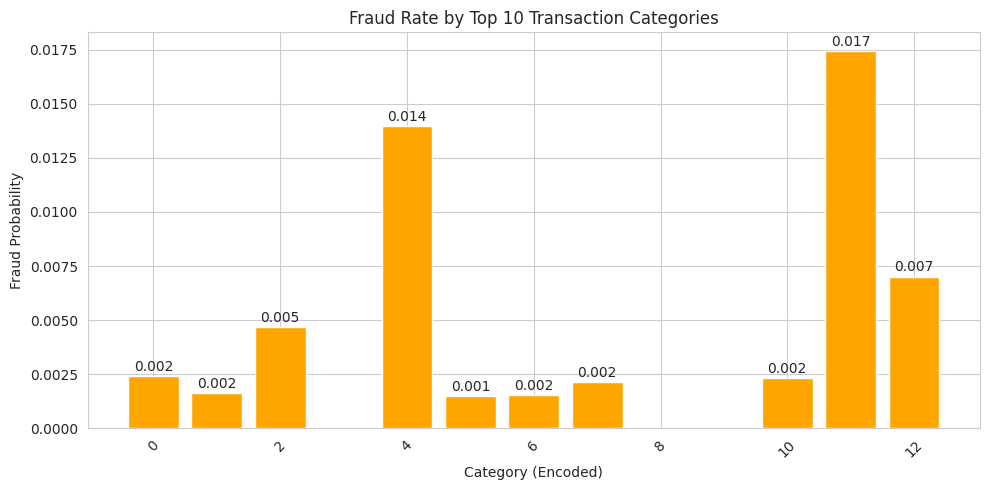

In [25]:
top_cats = df['category'].value_counts().index[:10]
fraud_by_cat = df[df['category'].isin(top_cats)].groupby('category')['is_fraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.bar(fraud_by_cat.index, fraud_by_cat.values, color='orange')
plt.title('Fraud Rate by Top 10 Transaction Categories')
plt.ylabel('Fraud Probability')
plt.xlabel('Category (Encoded)')
plt.xticks(rotation=45)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0001, f'{yval:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Visualizing distribution of log-transformed transaction amounts by fraud class


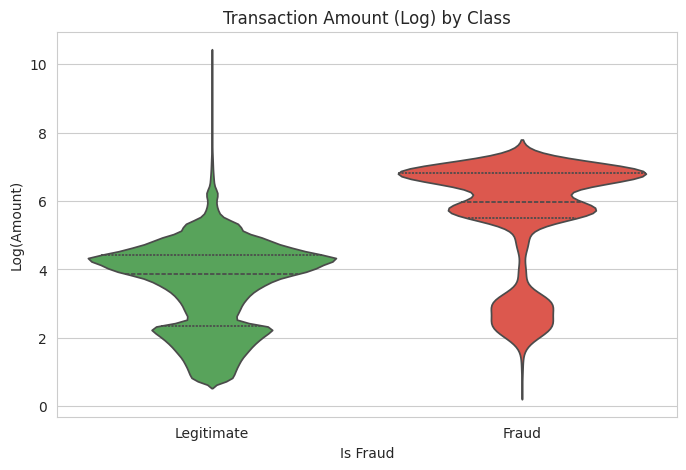

In [26]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='is_fraud', y='log_amt',
               palette=['#4CAF50', '#F44336'], inner='quartile')
plt.title('Transaction Amount (Log) by Class')
plt.xlabel('Is Fraud')
plt.ylabel('Log(Amount)')
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.show()

Tracking concept drift through fraud rate trends over time


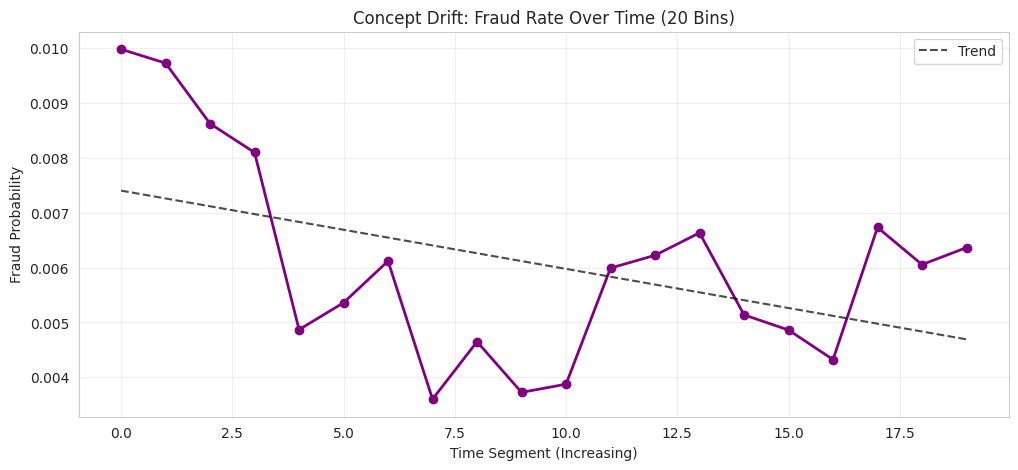

In [27]:
fraud_over_time = df.groupby('time_bin')['is_fraud'].agg(['mean', 'count'])
plt.figure(figsize=(12, 5))
plt.plot(fraud_over_time.index, fraud_over_time['mean'], 'o-', color='purple', linewidth=2)
plt.title('Concept Drift: Fraud Rate Over Time (20 Bins)')
plt.xlabel('Time Segment (Increasing)')
plt.ylabel('Fraud Probability')
plt.grid(True, alpha=0.3)
z = np.polyfit(fraud_over_time.index, fraud_over_time['mean'], 1)
p = np.poly1d(z)
plt.plot(fraud_over_time.index, p(fraud_over_time.index), "--", color='black', alpha=0.7, label='Trend')
plt.legend()
plt.show()

Analyzing combined effect of transaction distance and amount on fraud probability


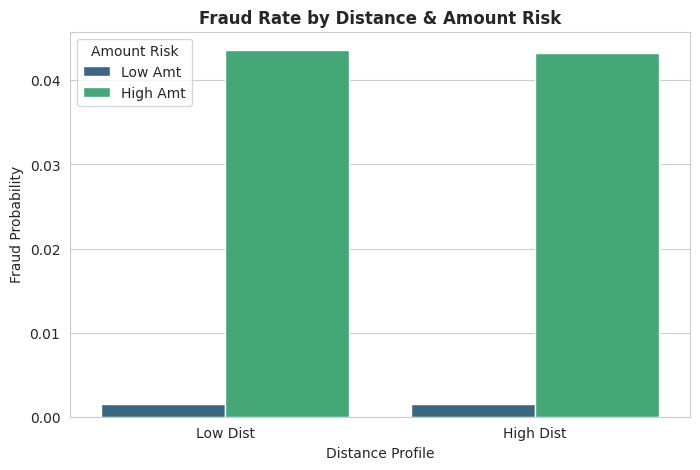

In [28]:
df['high_distance'] = df['distance_km'] > df['distance_km'].quantile(0.9)
df['high_amount'] = df['amt'] > df['amt'].quantile(0.9)

risk_table = pd.crosstab(
    [df['high_distance'], df['high_amount']],
    df['is_fraud'],
    normalize='index'
).round(4)

risk_pivot = risk_table.reset_index()
risk_pivot = risk_pivot.rename(columns={0: 'non_fraud_rate', 1: 'fraud_rate'})
risk_pivot['Distance_Risk'] = risk_pivot['high_distance'].map({True: 'High Dist', False: 'Low Dist'})
risk_pivot['Amount_Risk'] = risk_pivot['high_amount'].map({True: 'High Amt', False: 'Low Amt'})

plt.figure(figsize=(8, 5))
sns.barplot(
    data=risk_pivot,
    x='Distance_Risk',
    y='fraud_rate',
    hue='Amount_Risk',
    palette='viridis'
)
plt.title('Fraud Rate by Distance & Amount Risk', fontweight='bold')
plt.ylabel('Fraud Probability')
plt.xlabel('Distance Profile')
plt.legend(title='Amount Risk')
plt.show()

Analyzing demographic influence on fraud rate by age group and gender


<Figure size 1000x500 with 0 Axes>

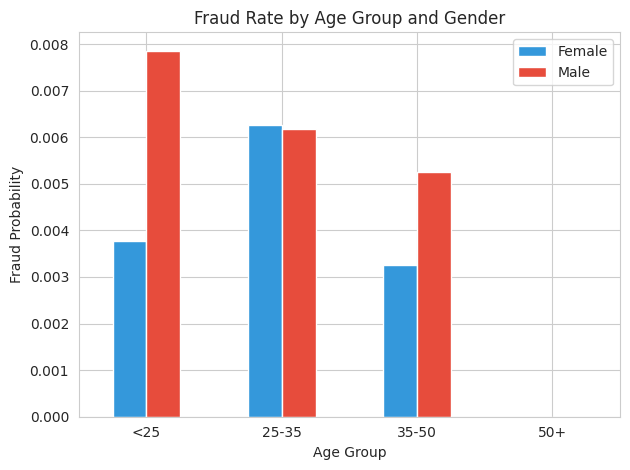

In [29]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 100], labels=['<25', '25-35', '35-50', '50+'])
fraud_by_demo = df.groupby(['age_group', 'gender'])['is_fraud'].mean().unstack()

plt.figure(figsize=(10, 5))
fraud_by_demo.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Fraud Rate by Age Group and Gender')
plt.ylabel('Fraud Probability')
plt.xlabel('Age Group')
plt.xticks(rotation=0)
plt.legend(['Female', 'Male'])
plt.tight_layout()
plt.show()

df['age'] = df['age'].clip(lower=0, upper=120)
bins = [0, 25, 35, 50, 65, 120]
labels = ['<25', '25-35', '35-50', '50-65', '65+']
df['age_group'] = pd.cut(
    df['age'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)
df['age_group'] = df['age_group'].astype('category').cat.add_categories(['Unknown']).fillna('Unknown')

Visualizing correlation relationships among numerical features


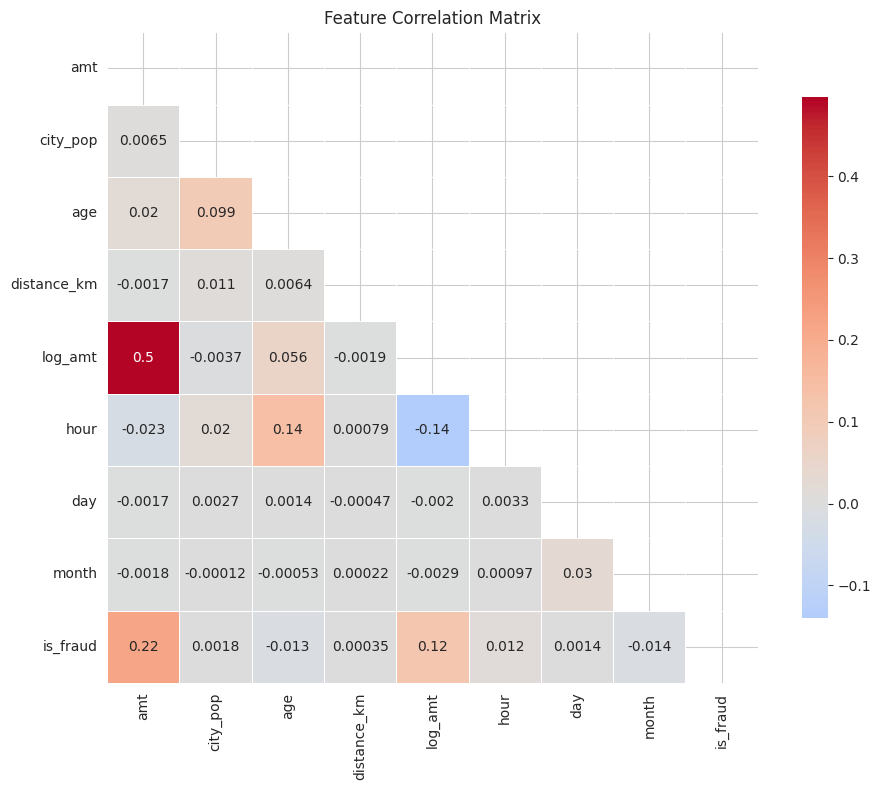

In [30]:
num_features = ['amt', 'city_pop', 'age', 'distance_km', 'log_amt', 'hour', 'day', 'month', 'is_fraud']
corr_matrix = df[num_features].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Capping outliers in numerical features using the IQR method


In [31]:
numerical_cols = ['amt', 'city_pop', 'age', 'distance_km', 'log_amt', 'hour', 'day', 'month']
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    capped = df[col].clip(lower_bound, upper_bound)
    outlier_pct = ((df[col] < lower_bound) | (df[col] > upper_bound)).mean() * 100
    return capped

df_capped = df.copy()
for col in numerical_cols:
    df_capped[col] = cap_outliers_iqr(df, col)

Visualizing numerical feature distributions before outlier capping


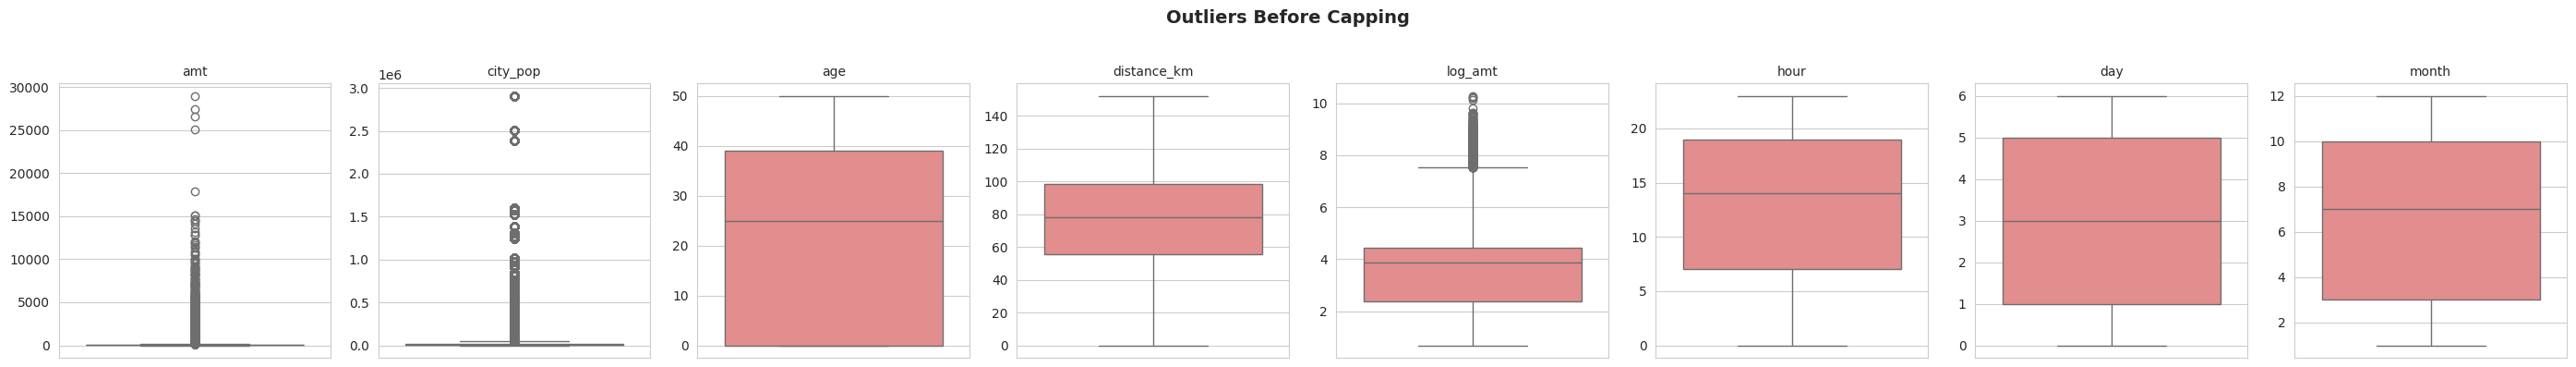

In [32]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(28, 4))
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, y=col, ax=axes[i], color='lightcoral')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle("Outliers Before Capping", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Visualizing numerical feature distributions after outlier capping


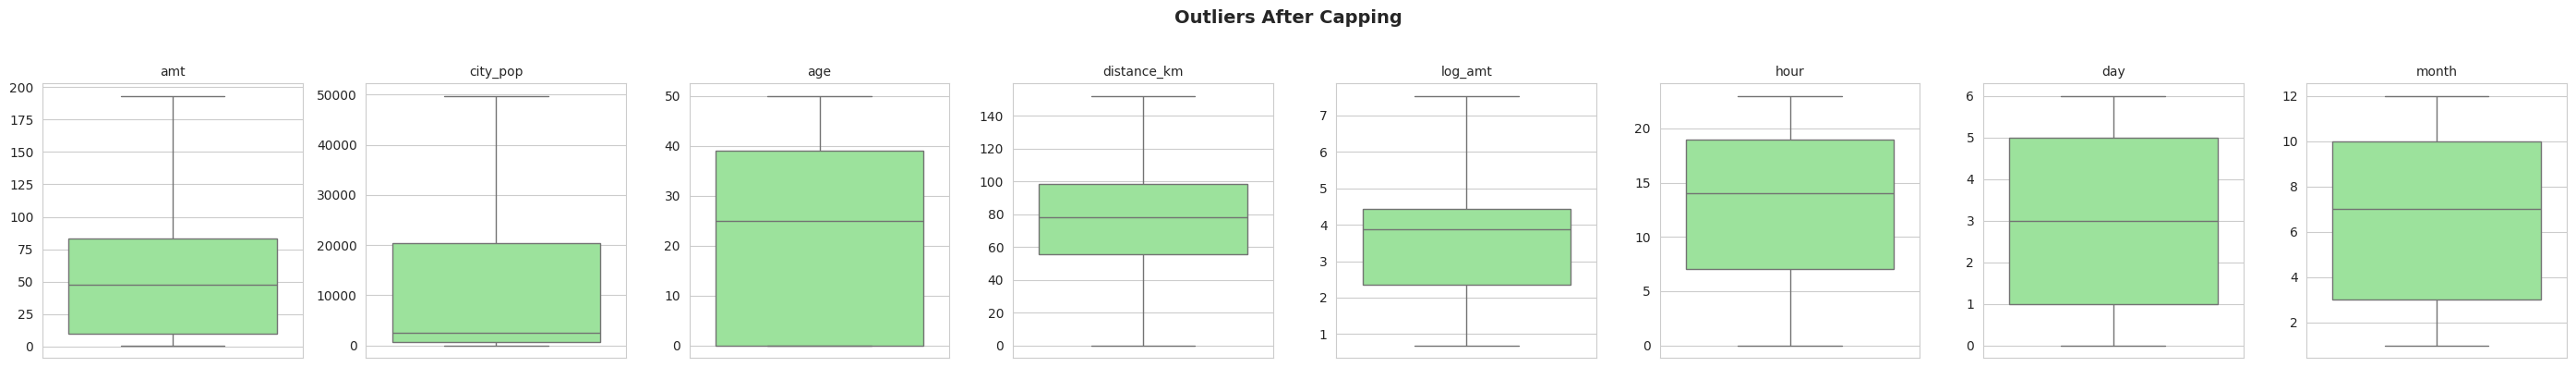

In [33]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(28, 4))
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df_capped, y=col, ax=axes[i], color='lightgreen')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle("Outliers After Capping", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Converting categorical and boolean columns to numeric using label encoding


In [34]:
from sklearn.preprocessing import LabelEncoder
df = df.copy()
for col in df.select_dtypes(include=['category', 'bool']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

print(" Conversion complete. Updated column data types:")
print(df.dtypes.value_counts())
display(df.head())

 Conversion complete. Updated column data types:
int64      12
float64     5
int32       3
Name: count, dtype: int64


,merchant,category,amt,gender,state,city_pop,job,unix_time,is_fraud,hour,day,month,age,distance_km,log_amt,time_bin,time_bin_cat,high_distance,high_amount,age_group
0,514,8,4.97,0,27,3495,370,1.325376e+09,0,0,1,1,37.0,78.597568,1.786747,0,0,0,0,1
1,241,4,107.23,0,47,149,428,1.325376e+09,0,0,1,1,47.0,30.212176,4.684259,0,0,0,0,1
2,390,0,220.11,1,13,4154,307,1.325376e+09,0,0,1,1,0.0,108.206083,5.398660,0,0,0,1,3
3,360,2,45.00,1,26,1939,328,1.325376e+09,0,0,1,1,0.0,95.673231,3.828641,0,0,0,0,3
4,297,9,41.96,1,45,99,116,1.325376e+09,0,0,1,1,39.0,77.556744,3.760269,0,0,0,0,1


Preparing and scaling final dataset for model training and evaluation


In [35]:
df_final = df_capped.copy()
df_final = df_final.drop(columns=['unix_time'], errors='ignore')

for col in df_final.columns:
    if col != 'is_fraud':
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
        df_final[col].fillna(df_final[col].median(), inplace=True)

X = df_final.drop(columns=['is_fraud'])
y = df_final['is_fraud']
N = min(30_000, len(df_final))
feature_names = X.columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values[:N])
X_raw = X.values[:N]
y_vals = y.values[:N].astype(int)

print(f" Data ready: {N} samples, {len(feature_names)} features")

 Data ready: 30000 samples, 18 features


Defining comprehensive evaluation function for classification model performance


In [36]:
def evaluate_comprehensive(y_true, y_pred, y_proba, model_name="Model"):
    y_true, y_pred, y_proba = np.array(y_true), np.array(y_pred), np.array(y_proba)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    auc_roc, auc_pr = 0.0, 0.0
    if len(np.unique(y_true)) > 1:
        try:
            auc_roc = roc_auc_score(y_true, y_proba)
            auc_pr = average_precision_score(y_true, y_proba)
        except:
            pass
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC_ROC': auc_roc,
        'AUC_PR': auc_pr,
        'TP': int(tp), 'FP': int(fp), 'TN': int(tn), 'FN': int(fn),
        'y_true': y_true, 'y_pred': y_pred, 'y_proba': y_proba
    }

Implementing adaptive streaming models with Hoeffding Tree and Adaptive Random Forest using drift detection


In [37]:
def run_hoeffding_raw(X, y, th=0.05):
    model = tree.HoeffdingTreeClassifier()
    preds, probs = [], []
    for i in range(len(X)):
        x = dict(zip(feature_names, X[i]))
        p = model.predict_proba_one(x).get(1, 0.0)
        preds.append(int(p >= th))
        probs.append(p)
        model.learn_one(x, y[i])
    return y, np.array(preds), np.array(probs)

def run_arf_raw(X, y, th=0.05):
    model = forest.ARFClassifier(n_models=10, seed=42)
    preds, probs = [], []
    for i in range(len(X)):
        x = dict(zip(feature_names, X[i]))
        p = model.predict_proba_one(x).get(1, 0.0)
        preds.append(int(p >= th))
        probs.append(p)
        model.learn_one(x, y[i])
    return y, np.array(preds), np.array(probs)

def run_arf_adwin_raw(X, y, th=0.05):
    model = forest.ARFClassifier(n_models=10, seed=42)
    dd = drift.ADWIN(delta=0.001)
    preds, probs = [], []
    for i in range(len(X)):
        x = dict(zip(feature_names, X[i]))
        p = model.predict_proba_one(x).get(1, 0.0)
        pred = int(p >= th)
        preds.append(pred)
        probs.append(p)
        dd.update(int(y[i] != pred))
        model.learn_one(x, y[i])
    return y, np.array(preds), np.array(probs)

def run_arf_ddm_raw(X, y, th=0.05):
    model = forest.ARFClassifier(n_models=10, seed=42)
    dd = drift.binary.DDM()
    preds, probs = [], []
    for i in range(len(X)):
        x = dict(zip(feature_names, X[i]))
        p = model.predict_proba_one(x).get(1, 0.0)
        pred = int(p >= th)
        preds.append(pred)
        probs.append(p)
        dd.update(int(y[i] != pred))
        model.learn_one(x, y[i])
    return y, np.array(preds), np.array(probs)

Implementing sliding window retraining strategy for Random Forest and XGBoost models


In [38]:
def run_rf_sliding_raw(X, y, window=2000, th=0.05, retrain_every=1000):
    model = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)
    model.fit(X[:window], y[:window])
    preds, probs = [], []
    next_retrain = window + retrain_every

    for i in range(window, len(X)):
        proba = model.predict_proba(X[i:i+1])[0]
        p_fraud = proba[1] if len(proba) > 1 else 0.0
        preds.append(int(p_fraud >= th))
        probs.append(p_fraud)

        if i >= next_retrain:
            start = max(0, i - window + 1)
            model.fit(X[start:i+1], y[start:i+1])
            next_retrain = i + retrain_every
    return y[window:], np.array(preds), np.array(probs)

def run_xgb_sliding_raw(X, y, window=2000, th=0.05, retrain_every=1000):
    model = xgb.XGBClassifier(
        n_estimators=30,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        base_score=0.5
    )
    model.fit(X[:window], y[:window])
    preds, probs = [], []
    next_retrain = window + retrain_every

    for i in range(window, len(X)):
        proba = model.predict_proba(X[i:i+1])[0]
        p_fraud = proba[1] if len(proba) > 1 else 0.0
        preds.append(int(p_fraud >= th))
        probs.append(p_fraud)

        if i >= next_retrain:
            start = max(0, i - window + 1)
            model.fit(X[start:i+1], y[start:i+1])
            next_retrain = i + retrain_every

    return y[window:], np.array(preds), np.array(probs)

Evaluating and comparing performance metrics across all adaptive and traditional models


In [39]:
print(" Running all 6 models...")
y_t, y_p_h, y_pr_h = run_hoeffding_raw(X_raw, y_vals)
y_t, y_p_a, y_pr_a = run_arf_raw(X_raw, y_vals)
y_t, y_p_adw, y_pr_adw = run_arf_adwin_raw(X_raw, y_vals)
y_t, y_p_ddm, y_pr_ddm = run_arf_ddm_raw(X_raw, y_vals)
y_t_rf, y_p_rf, y_pr_rf = run_rf_sliding_raw(X_scaled, y_vals)
y_t_xgb, y_p_xgb, y_pr_xgb = run_xgb_sliding_raw(X_scaled, y_vals)

results = [
    evaluate_comprehensive(y_t, y_p_h, y_pr_h, "Hoeffding"),
    evaluate_comprehensive(y_t, y_p_a, y_pr_a, "ARF"),
    evaluate_comprehensive(y_t, y_p_adw, y_pr_adw, "ARF+ADWIN"),
    evaluate_comprehensive(y_t, y_p_ddm, y_pr_ddm, "ARF+DDM"),
    evaluate_comprehensive(y_t_rf, y_p_rf, y_pr_rf, "Random Forest"),
    evaluate_comprehensive(y_t_xgb, y_p_xgb, y_pr_xgb, "XGBoost")
]

print("\n" + "="*100)
print("FULL EVALUATION: ALL METRICS FOR ALL MODELS")
print("="*130)
print(f"{'Model':<18} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'AUC_ROC':<9} {'AUC_PR':<9} {'TP':<6} {'FP':<6}")
print("-"*130)
for r in results:
    print(f"{r['Model']:<18} {r['Accuracy']:<8.4f} {r['Precision']:<8.4f} {r['Recall']:<8.4f} "
          f"{r['F1']:<8.4f} {r['AUC_ROC']:<9.4f} {r['AUC_PR']:<9.4f} {r['TP']:<6} {r['FP']:<6}")

best_model = max(results, key=lambda x: x['F1'])
print(f"\n Best Model by F1: {best_model['Model']} (F1={best_model['F1']:.4f})")

 Running all 6 models...

FULL EVALUATION: ALL METRICS FOR ALL MODELS
Model              Acc      Prec     Recall   F1       AUC_ROC   AUC_PR    TP     FP    
----------------------------------------------------------------------------------------------------------------------------------
Hoeffding          0.9904   0.0000   0.0000   0.0000   0.6120    0.0125    0      0     
ARF                0.9615   0.1432   0.6042   0.2315   0.8391    0.3811    174    1041  
ARF+ADWIN          0.9615   0.1432   0.6042   0.2315   0.8391    0.3811    174    1041  
ARF+DDM            0.9615   0.1432   0.6042   0.2315   0.8391    0.3811    174    1041  
Random Forest      0.9604   0.1824   0.8194   0.2984   0.9219    0.5950    236    1058  
XGBoost            0.9674   0.1959   0.6979   0.3059   0.9021    0.5093    201    825   

 Best Model by F1: XGBoost (F1=0.3059)


Visualizing ROC and Precision-Recall curves to compare model discrimination and fraud detection effectiveness


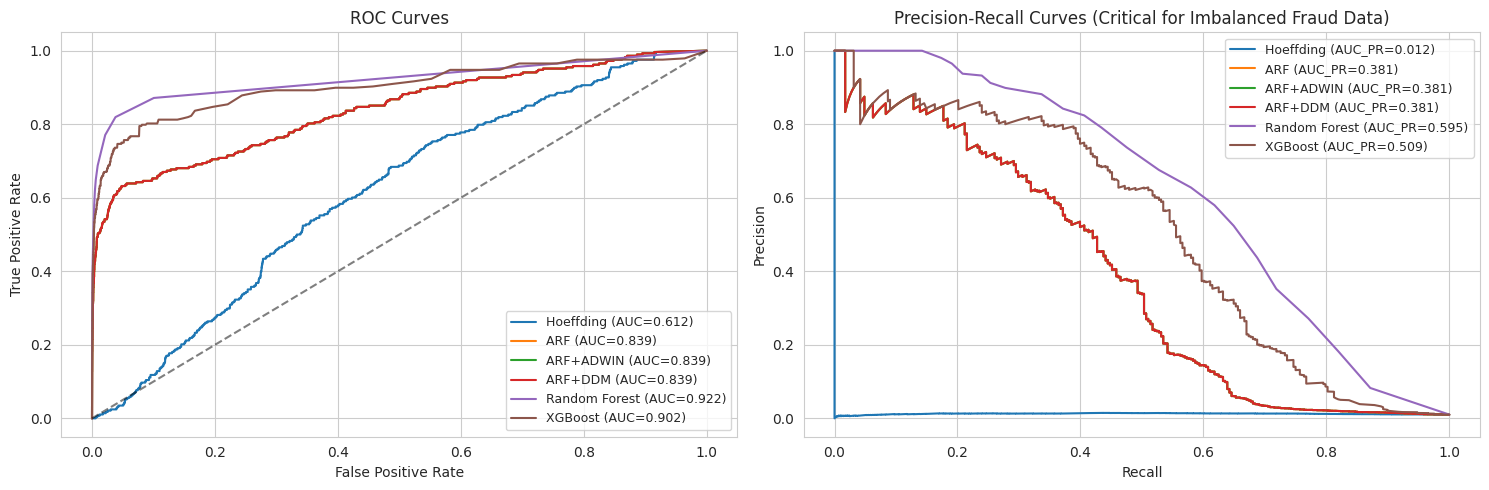


 Fraud Detection Performance of Best Model (XGBoost):
 Detected 201 fraud transactions
 Missed 87 fraud transactions (false negatives)
 Generated 825 false alerts

 Recommendation: Use XGBoost with threshold tuning for real-time fraud detection.


In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for r in results:
    fpr, tpr, _ = roc_curve(r['y_true'], r['y_proba'])
    ax1.plot(fpr, tpr, label=f"{r['Model']} (AUC={r['AUC_ROC']:.3f})")

    prec_vals, rec_vals, _ = precision_recall_curve(r['y_true'], r['y_proba'])
    ax2.plot(rec_vals, prec_vals, label=f"{r['Model']} (AUC_PR={r['AUC_PR']:.3f})")

ax1.plot([0,1], [0,1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(fontsize=9)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves (Critical for Imbalanced Fraud Data)')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n Fraud Detection Performance of Best Model ({best_model['Model']}):")
print(f" Detected {best_model['TP']} fraud transactions")
print(f" Missed {best_model['FN']} fraud transactions (false negatives)")
print(f" Generated {best_model['FP']} false alerts")
print(f"\n Recommendation: Use {best_model['Model']} with threshold tuning for real-time fraud detection.")

Tuning and retraining XGBoost model using grid search for optimal hyperparameters


In [41]:
X_tune = X_scaled[:10_000]
y_tune = y_vals[:10_000]

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    base_score=0.5
)

grid = GridSearchCV(
    xgb_base,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)
grid.fit(X_tune, y_tune)

print(f" Best params: {grid.best_params_}")
print(f" Best F1 (CV): {grid.best_score_:.4f}")

X_train_full = X_scaled[:20_000]
y_train_full = y_vals[:20_000]
best_xgb = grid.best_estimator_
best_xgb.fit(X_train_full, y_train_full)

print(" XGBoost retrained with best hyperparameters.")

 Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
 Best F1 (CV): 0.6924
 XGBoost retrained with best hyperparameters.


Analyzing and visualizing XGBoost feature importance using built-in and permutation methods


 Feature Importance Analysis (Without SHAP)


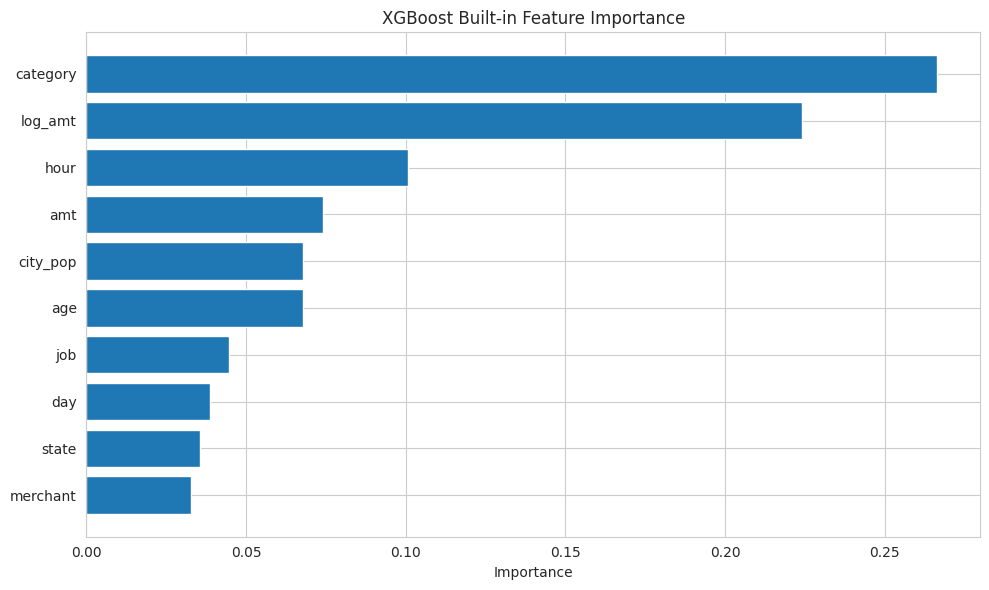

Top 10 Features (XGBoost Built-in):
  1. category: 0.2665
  2. log_amt: 0.2241
  3. hour: 0.1008
  4. amt: 0.0740
  5. city_pop: 0.0679
  6. age: 0.0678
  7. job: 0.0446
  8. day: 0.0387
  9. state: 0.0357
  10. merchant: 0.0328

 Calculating Permutation Importance... 


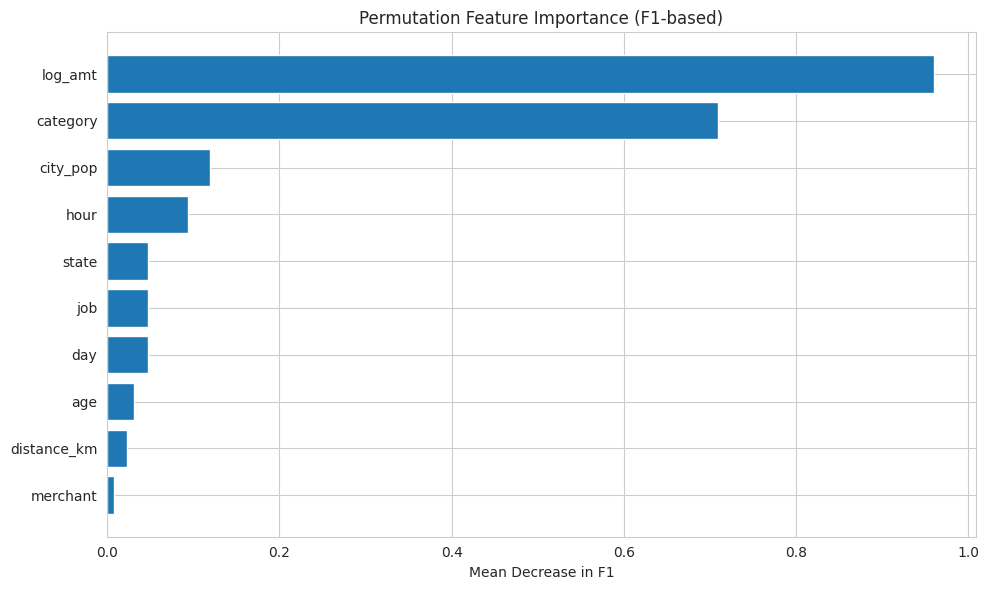


Top 10 Features (Permutation Importance):
  1. log_amt: 0.9608
  2. category: 0.7095
  3. city_pop: 0.1193
  4. hour: 0.0936
  5. state: 0.0476
  6. job: 0.0476
  7. day: 0.0469
  8. age: 0.0314
  9. distance_km: 0.0233
  10. merchant: 0.0078

 Key Insight: 'log_amt' is the strongest fraud indicator.


In [42]:
print(" Feature Importance Analysis (Without SHAP)")
xgb_importance = best_xgb.feature_importances_
xgb_features = sorted(zip(feature_names, xgb_importance), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
feats, imps = zip(*xgb_features[:10])
plt.barh(range(len(imps)), imps)
plt.yticks(range(len(imps)), feats)
plt.gca().invert_yaxis()
plt.title("XGBoost Built-in Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("Top 10 Features (XGBoost Built-in):")
for i, (feat, imp) in enumerate(xgb_features[:10], 1):
    print(f"  {i}. {feat}: {imp:.4f}")

print("\n Calculating Permutation Importance... ")
X_sample = X_scaled[:5000]
y_sample = y_vals[:5000]

perm_imp = permutation_importance(
    best_xgb,
    X_sample,
    y_sample,
    n_repeats=3,
    random_state=42,
    scoring='f1'
)

perm_features = sorted(
    zip(feature_names, perm_imp.importances_mean),
    key=lambda x: x[1],
    reverse=True
)

plt.figure(figsize=(10, 6))
feats, imps = zip(*perm_features[:10])
plt.barh(range(len(imps)), imps)
plt.yticks(range(len(imps)), feats)
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (F1-based)")
plt.xlabel("Mean Decrease in F1")
plt.tight_layout()
plt.show()

print("\nTop 10 Features (Permutation Importance):")
for i, (feat, imp) in enumerate(perm_features[:10], 1):
    print(f"  {i}. {feat}: {imp:.4f}")

best_feature = perm_features[0][0]
print(f"\n Key Insight: '{best_feature}' is the strongest fraud indicator.")